In [472]:
# data manipulation
import pandas as pd
import numpy as np
import re

# to make custom estimators
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

# to divide train and test set
from sklearn.model_selection import train_test_split

# to make pipelines
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

# Model_Selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

# ML algorithms 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# correlation
from sklearn.feature_selection import SelectKBest, f_classif

import warnings
warnings.filterwarnings("ignore")

# plot graphics
import matplotlib.pyplot as plt
import seaborn as sns

# Feature engineer 
from feature_engine.selection import DropFeatures
from feature_engine.encoding import OneHotEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.imputation import (AddMissingIndicator,MeanMedianImputer, CategoricalImputer)

In [2]:
#nice setup for graphics cause why not: pretty blue and another pretty blue
colors = ['#06344d', '#00b2ff']
sns.set(palette = colors, font = 'Serif', style = 'white', 
        rc = {'axes.facecolor':'#f1f1f1', 'figure.facecolor':'#f1f1f1'})

# Load Data

In [227]:
df = pd.read_csv("Dados/train.csv",index_col=0)

x = df.drop('Survived',axis=1)
y = df.Survived

In [228]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state = 42)

In [5]:
class Fill_na_transf(BaseEstimator, TransformerMixin):
    """Fills NA with fill_na value"""
    
    def __init__(self,fill_na):
        self.fill_na = fill_na
    
    def fit(self, x:pd.DataFrame ,y:pd.Series=None):
        return self
    
    def transform(self,x:pd.DataFrame):
        x = x.copy()
        x = x.replace(np.nan, self.fill_na)
        return x

class Cabin_code(BaseEstimator, TransformerMixin):
    """Create column with first character of the first Cabin and how many cabins"""
    
    def __init__(self):
        pass
    def fit(self, x:pd.DataFrame ,y:pd.Series=None):
        return self
    
    def transform(self,x:pd.DataFrame):
        x = x.copy()
        x['Cabin_code'] = x['Cabin'].apply(lambda x: x[0])
        x['Cabin_Size'] = x['Cabin'].apply(lambda x: len(x.split(" ")))
        return x

class Mapper(BaseEstimator, TransformerMixin):
    """Create column with first character of the first Cabin and how many cabins"""
    
    def __init__(self,features:list,map_dict:dict):
        
        if not isinstance(features,list):
            raise ValueError('Features should be a list')
            
        self.features = features
        self.map_dict = map_dict
        pass
    
    def fit(self, x:pd.DataFrame ,y:pd.Series=None):
        return self
    
    def transform(self,x:pd.DataFrame):
        x = x.copy()
        for feature in self.features:
            x[feature] = x[feature].map(self.map_dict)
        return x
    
#dict for enconding "Sex"
sex_map = {'male':1,
          'female':0,
          '?':-999}

class Get_title(BaseEstimator, TransformerMixin):
    """Create column with title from 'Name' """
    
    def __init__(self):
        pass
    
    def fit(self, x:pd.DataFrame ,y:pd.Series=None):
        return self
    
    def transform(self,x:pd.DataFrame, y:pd.Series=None):
        x = x.copy()
        x['Title'] = x['Name'].apply(return_title)
        return x

class Get_family(BaseEstimator, TransformerMixin):
    """Create column with title from 'Name' """
    
    def __init__(self):
        pass
    
    def fit(self, x:pd.DataFrame ,y:pd.Series=None):
        return self
    
    def transform(self,x:pd.DataFrame, y:pd.Series=None):
        x = x.copy()
        x['Family'] = x['Name'].apply(return_family)
        return x

def return_title(passenger):
    line = passenger
    if re.search('Mrs', line):
        return 'Mrs'
    elif re.search('Mr', line):
        return 'Mr'
    elif re.search('Miss', line):
        return 'Miss'
    elif re.search('Master', line):
        return 'Master'
    else:
        return 'Other'

def return_family(passanger):
    line = passanger
    return line['Name'].iloc[0].split(',')[0]
    
def corrige_type(df):
    df=df.copy()
    df['Pclass']=df['Pclass'].astype('int')
    df['Sex']=df['Sex'].astype('')

# Exploratory Data Analysis

In [6]:
x_train.head(2)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
446,1,"Dodge, Master. Washington",male,4.0,0,2,33638,81.8583,A34,S
651,3,"Mitkoff, Mr. Mito",male,NaN,0,0,349221,7.8958,NaN,S


In [7]:
x_train.isnull().sum().sort_values(ascending=False).head()

Cabin       484
Age         124
Embarked      1
Pclass        0
Name          0
dtype: int64

In [8]:
#basic pre processing 
pipe_preproc = make_pipeline(
                        Fill_na_transf(fill_na="?"),
                        Cabin_code(),
                        Get_title(),
                        Mapper(features=['Sex'],map_dict = sex_map),
                        DropFeatures(features_to_drop=['Name','Ticket','Cabin']))

In [9]:
x_eda = pipe_preproc.fit_transform(x_train)

In [10]:
x1 = pipe_preproc.fit_transform(x)

In [11]:
x_eda.head(2)

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_code,Cabin_Size,Title
PassengerId,,,,,,,,,,
446,1,1,4.0,0,2,81.8583,S,A,1,Master
651,3,1,?,0,0,7.8958,S,?,1,Mr


In [12]:
num_var = ['Pclass','Age','SibSp','Parch','Fare','Cabin_Size']
cat_var = ['Sex','Cabin_code','Embarked','Title']
target = ['Survived']

## Understanding the columns

- `PassangerId` - numerical ID, works as an Index. Doesn't have value for the model we're going to built.
- `Survived` - boolean var meaning (0 = did not survived, 1 = survived)
- `Pclass` - travel class, being 1st class the most luxurious and expensive and 3rd class the most cheap
- `Name` - passanger's names and names their relatives in parenthesis
- `SibSp` - how many siblings the passanger had in titanic
- `Parch` -  how many parents/childs the passanger had on board
- `Ticket` - ticket's code, doesn't have value for the model we're going to built.
- `Fare` - how much the ticket cost
- `Embarked` - Port of embarkation: C = Cherbourg, Q = Queenstown, S = Southampton 

In [13]:
x_eda.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 446 to 103
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      623 non-null    int64  
 1   Sex         623 non-null    int64  
 2   Age         623 non-null    object 
 3   SibSp       623 non-null    int64  
 4   Parch       623 non-null    int64  
 5   Fare        623 non-null    float64
 6   Embarked    623 non-null    object 
 7   Cabin_code  623 non-null    object 
 8   Cabin_Size  623 non-null    int64  
 9   Title       623 non-null    object 
dtypes: float64(1), int64(5), object(4)
memory usage: 53.5+ KB


## Cardinality of Categorical Vars

<AxesSubplot:>

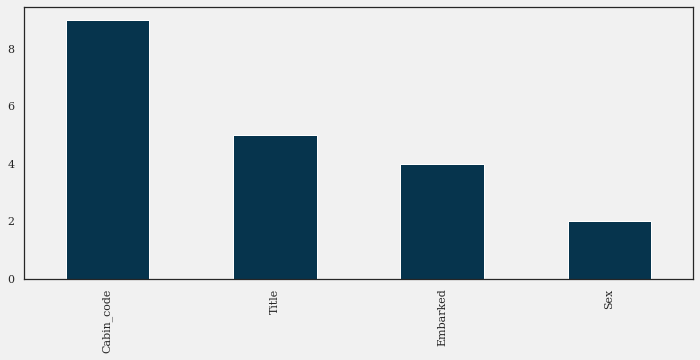

In [14]:
x_eda[cat_var].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

In [15]:
x_train.nunique()

Pclass        3
Name        623
Sex           2
Age          77
SibSp         7
Parch         7
Ticket      495
Fare        207
Cabin       106
Embarked      3
dtype: int64

## Variables Distribution

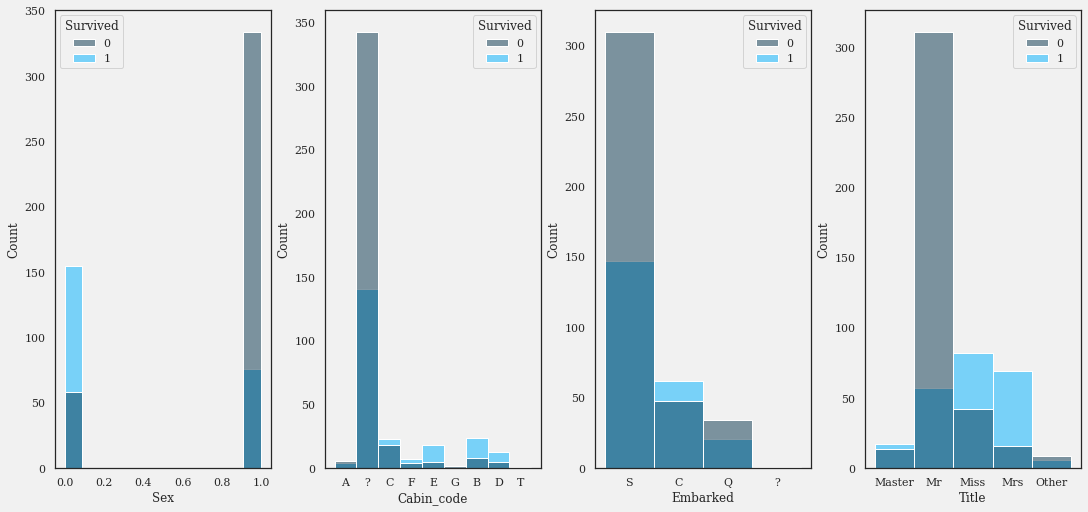

In [16]:
#creating the plot "frames"
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 7), constrained_layout = True)

#filling the frames with the bars
for i, col in enumerate(cat_var): 
    sns.histplot(data = x_eda, x = col, hue = y_train, ax = ax[i])

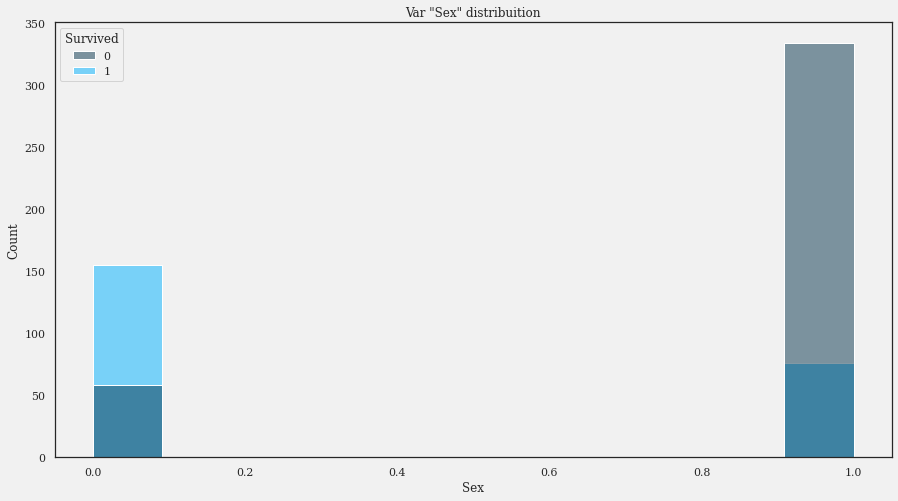

In [17]:
plt.subplots(figsize=(15,8))
sns.histplot(data = x_eda, x = 'Sex', hue = y_train)
plt.title('Var "Sex" distribuition')
plt.show()

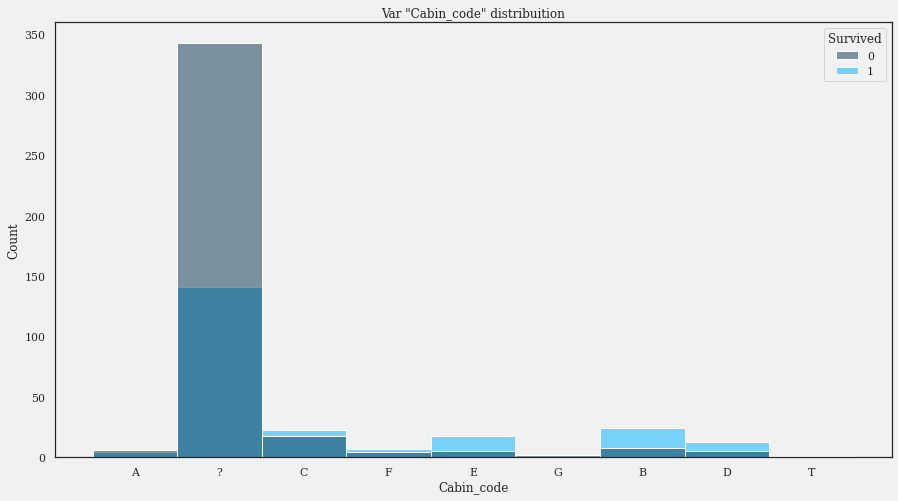

In [18]:
plt.subplots(figsize=(15,8))
sns.histplot(data = x_eda, x = 'Cabin_code', hue = y_train)
plt.title('Var "Cabin_code" distribuition')
plt.show()

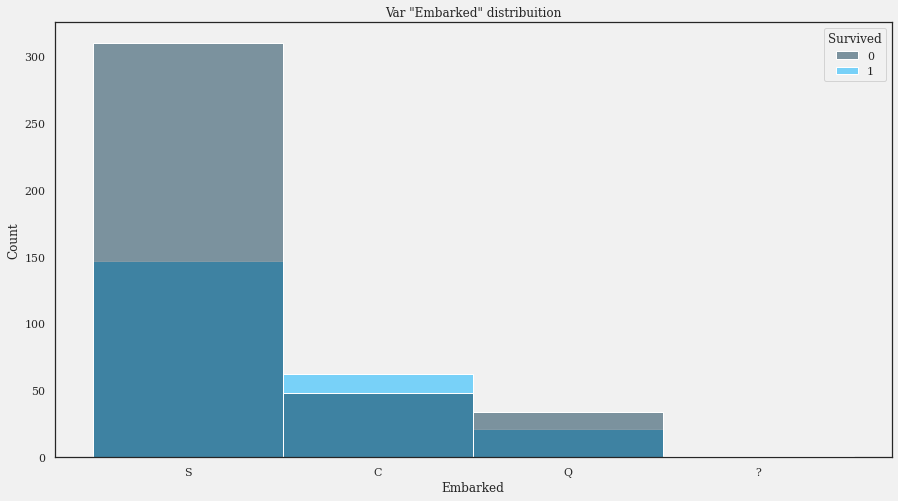

In [19]:
plt.subplots(figsize=(15,8))
sns.histplot(data = x_eda, x = 'Embarked', hue = y_train)
plt.title('Var "Embarked" distribuition')
plt.show()

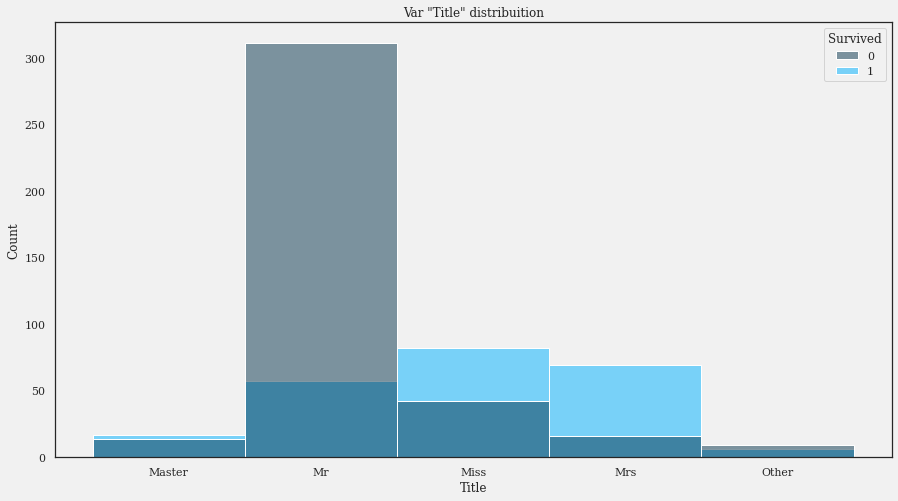

In [20]:
plt.subplots(figsize=(15,8))
sns.histplot(data = x_eda, x = 'Title', hue = y_train)
plt.title('Var "Title" distribuition')
plt.show()

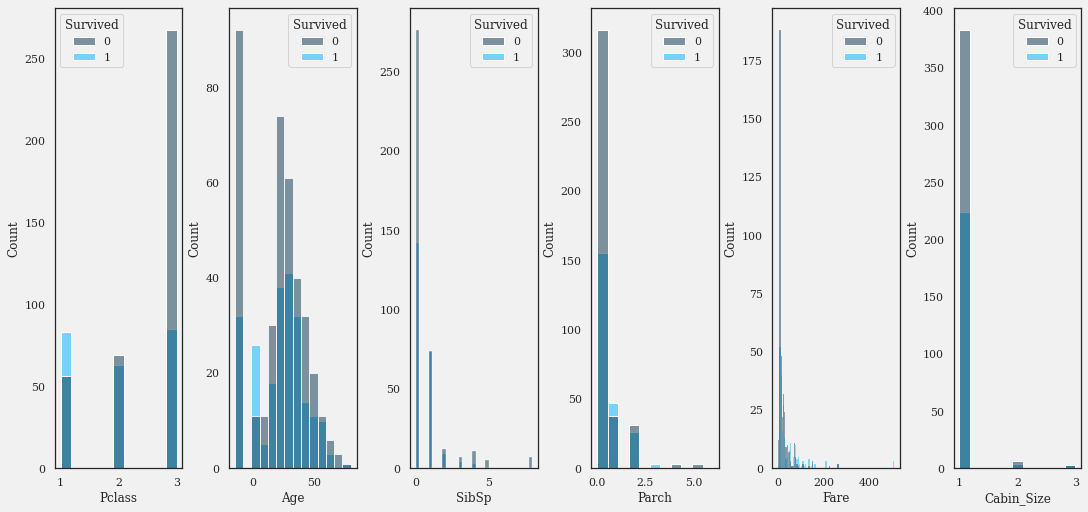

In [24]:
#creating the plot "frames"
fig, ax = plt.subplots(nrows = 1, ncols = 6, figsize = (15, 7), constrained_layout = True)
x_eda2 = x_eda.replace('?', -15)

hist_num_vars = [x for x in num_var if x not in ["Age"]]
#filling the frames with the bars
for i, col in enumerate(num_var): 
    sns.histplot(data = x_eda2, x = col, hue = y_train, ax = ax[i])

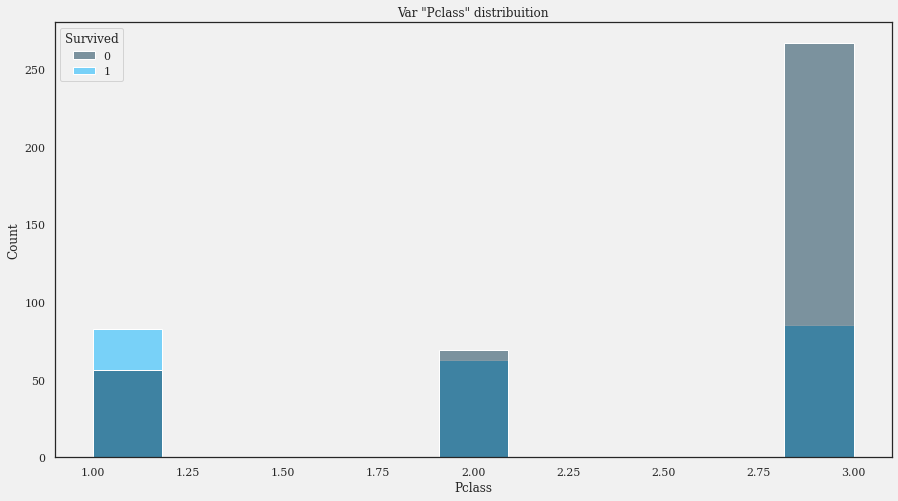

In [25]:
plt.subplots(figsize=(15,8))
sns.histplot(data = x_eda, x = 'Pclass', hue = y_train)
plt.title('Var "Pclass" distribuition')
plt.show()

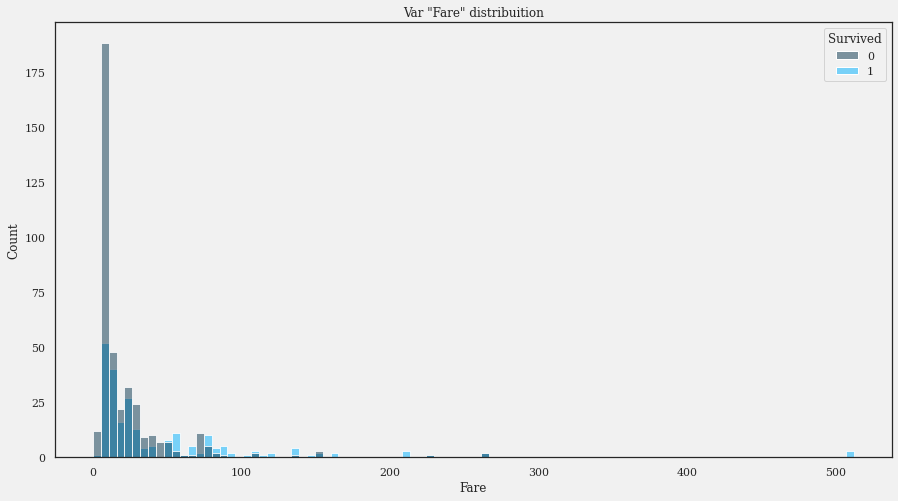

In [26]:
plt.subplots(figsize=(15,8))
sns.histplot(data = x_eda, x = 'Fare', hue = y_train)
plt.title('Var "Fare" distribuition')
plt.show()

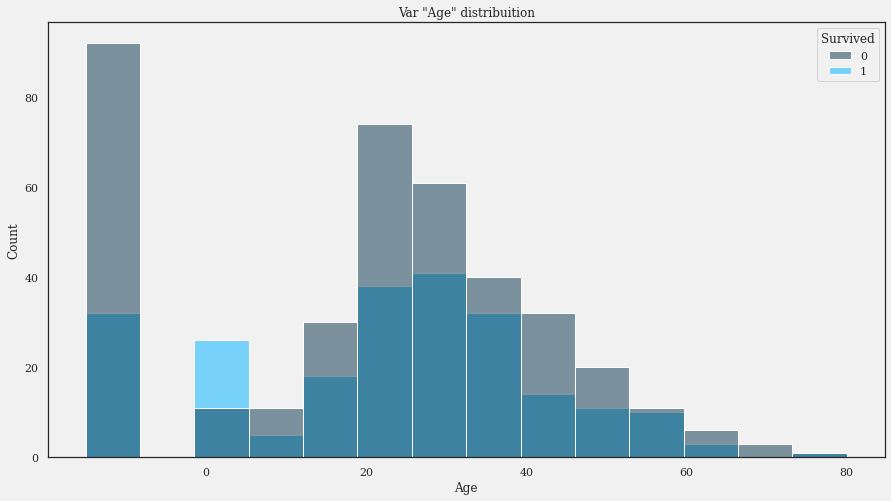

In [28]:
plt.subplots(figsize=(15,8))
sns.histplot(data = x_eda2, x = 'Age', hue = y_train)
plt.title('Var "Age" distribuition')
plt.show()

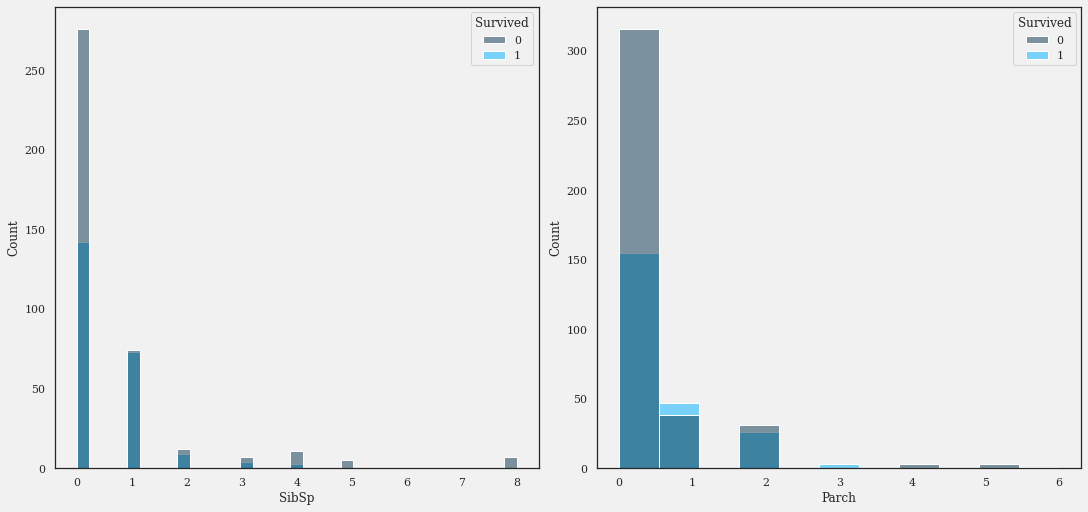

In [29]:
#creating the plot "frames"
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 7), constrained_layout = True)

#filling the frames with the bars
for i, col in enumerate(['SibSp','Parch']): 
    sns.histplot(data = x_eda, x = col, hue = y_train, ax = ax[i])

<function matplotlib.pyplot.show(close=None, block=None)>

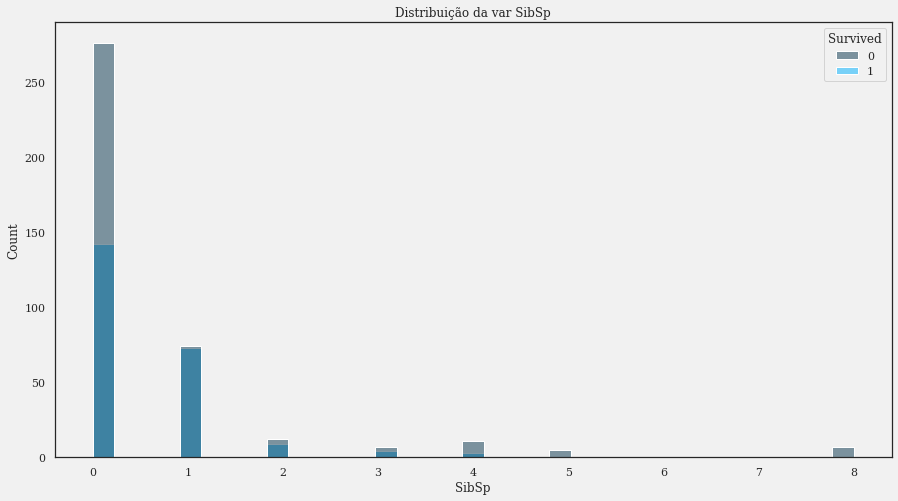

In [30]:
plt.subplots(figsize=(15,8))
sns.histplot(data = x_eda, x = 'SibSp', hue = y_train)
plt.title('Distribuição da var SibSp')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

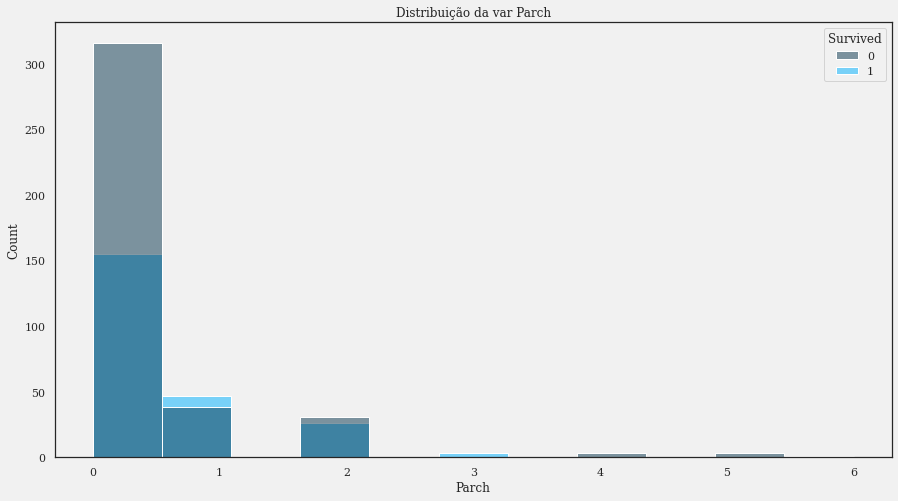

In [31]:
plt.subplots(figsize=(15,8))
sns.histplot(data = x_eda, x = 'Parch', hue = y_train)
plt.title('Distribuição da var Parch')
plt.show

In [33]:
x_train[x_train['Parch']==5].join(y_train)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
PassengerId,,,,,,,,,,,
639,3,"Panula, Mrs. Juha (Maria Emilia Ojala)",female,41.0,0,5,3101295,39.6875,NaN,S,0
611,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S,0
14,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S,0


In [34]:
x_train[x_train['SibSp']==4].join(y_train).groupby("Survived").count()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,
0,11,11,11,11,11,11,11,11,0,11
1,3,3,3,3,3,3,3,3,0,3


In [35]:
x_train[['SibSp','Age']].groupby("SibSp").count()

,Age
SibSp,
0,323
1,130
2,18
3,9
4,14
5,5
8,0


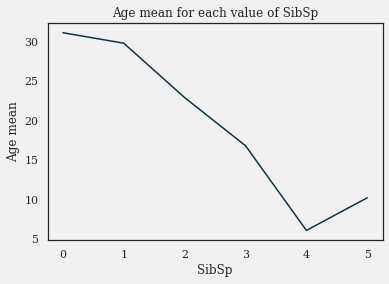

In [36]:
plt.plot(x_train[['SibSp','Age']].groupby("SibSp").mean())
plt.title('Age mean for each value of SibSp')
plt.xlabel('SibSp')
plt.ylabel('Age mean')
plt.show()

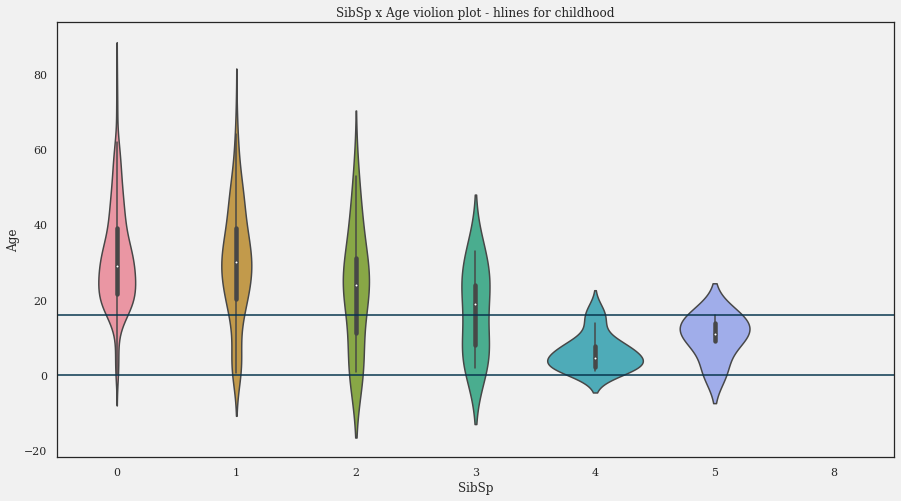

In [37]:
plt.subplots(figsize=(15,8))
sns.violinplot(x_train['SibSp'],x_train['Age'])
plt.axhline(y=0)
plt.axhline(y=16)
plt.title('SibSp x Age violion plot - hlines for childhood')
plt.xlabel('SibSp')
plt.ylabel('Age')
plt.show()

In [38]:
x_train[x_train['SibSp']==4]['Age'].mean()

6.071428571428571

In [39]:
x_train[x_train['SibSp']==3].join(y_train).groupby("Survived").count()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,
0,7,7,7,5,7,7,7,7,1,7
1,4,4,4,4,4,4,4,4,2,4


In [41]:
x_train[x_train['Age']>55].join(y_train).head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
PassengerId,,,,,,,,,,,
695,1,"Weir, Col. John",male,60.0,0,0,113800,26.5500,NaN,S,0
588,1,"Frolicher-Stehli, Mr. Maxmillian",male,60.0,1,1,13567,79.2000,B41,C,1
571,2,"Harris, Mr. George",male,62.0,0,0,S.W./PP 752,10.5000,NaN,S,1
880,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C,1
95,3,"Coxon, Mr. Daniel",male,59.0,0,0,364500,7.2500,NaN,S,0


Vamos testar se aplicar uma transformação logarítimica melhor ainda mais a distribuição de "Age" ou não.

In [53]:
x_eda_age= x_eda.copy()
x_eda_age['Age'] =  x_eda['Age'].replace("?",np.nan)
x_eda_age['Age'] = np.log(x_eda_age['Age']) 

<AxesSubplot:xlabel='Age', ylabel='Count'>

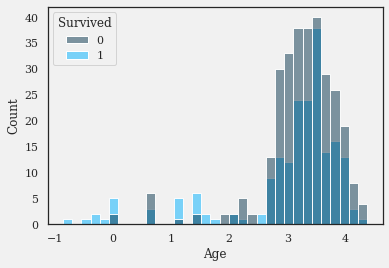

In [54]:
sns.histplot(data = x_eda_age, x = "Age", hue = y_train)

Agora comparando à original:

<AxesSubplot:xlabel='Age', ylabel='Count'>

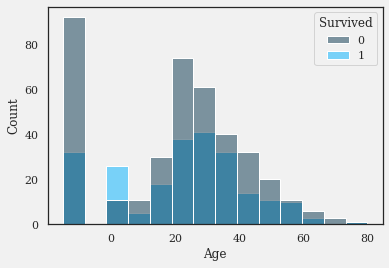

In [55]:
sns.histplot(data = x_eda2, x = "Age", hue = y_train)

Vemos que a transformação piorou a distruibuição, então, não vamos usá-la. Vamos tentar a mesma técnica para a variável "Fare".

<AxesSubplot:xlabel='Fare', ylabel='Count'>

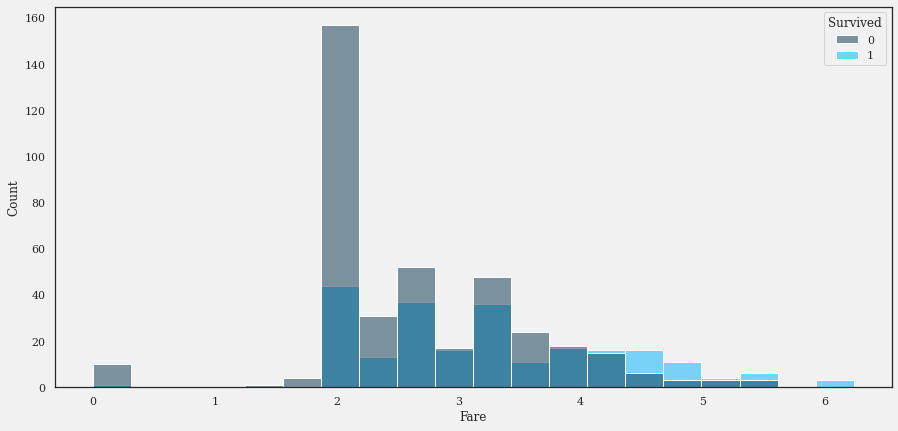

In [56]:
x_eda1= x_eda.copy()
x_eda1['Fare'] =  x_eda1['Fare'].replace(0,1)
x_eda1['Fare'] = np.log(x_eda1['Fare']) 

plt.subplots(figsize = (15, 7))
sns.histplot(data = x_eda1, x = "Fare", hue = y_train)

Comparando à original:

<AxesSubplot:xlabel='Fare', ylabel='Count'>

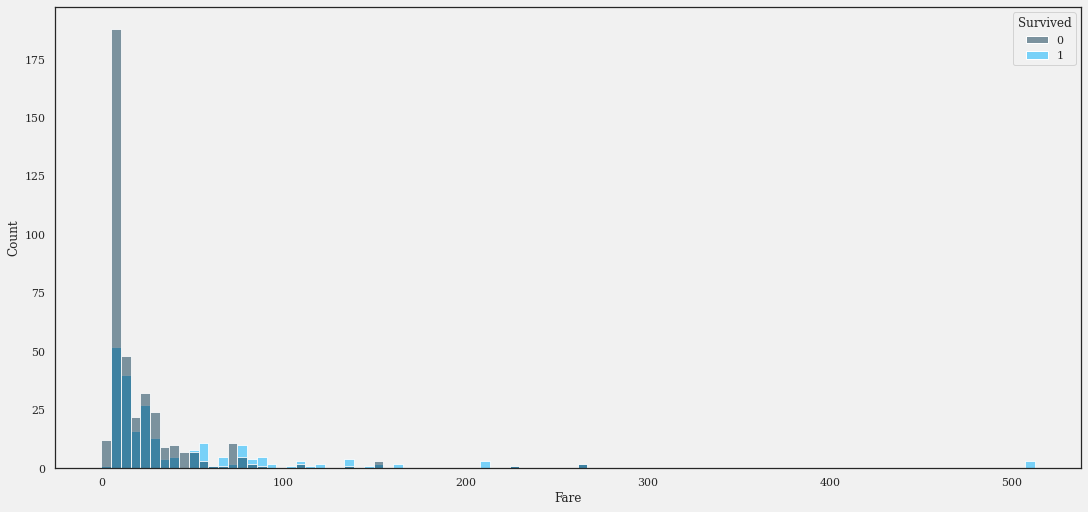

In [57]:
#creating the plot "frames"
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 7), constrained_layout = True)
sns.histplot(data = x_eda, x = "Fare", hue = y_train)

<AxesSubplot:xlabel='Pclass', ylabel='Count'>

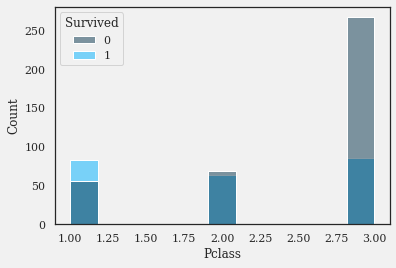

In [58]:
sns.histplot(data = x_eda, x = "Pclass", hue = y_train)

## Rare Labels

Labels raros são classes que tem poucas ocorrências. É uma boa prática remover essas para evitar overfitting. Vamos identificar as classes que tem menos de 5% do dataset de ocorrência.

In [59]:
def find_frequent_labels(df, var, rare_perc):
    # function finds the labels that are shared by more than
    # a certain % of the ocurrences in the dataset
  
    df = df.copy()
    tmp = df.groupby(var)[var].count() / len(df)
    return tmp[tmp > rare_perc].index

In [68]:
for var in ['Sex','Embarked', 'Cabin_code', 'Title','Pclass']:
    # find the frequent categories
    frequent_ls = find_frequent_labels(x_eda, var, 0.05)
    print(var, frequent_ls)
    print()

Sex Int64Index([0, 1], dtype='int64', name='Sex')

Embarked Index(['C', 'Q', 'S'], dtype='object', name='Embarked')

Cabin_code Index(['?', 'B', 'C'], dtype='object', name='Cabin_code')

Title Index(['Miss', 'Mr', 'Mrs'], dtype='object', name='Title')

Pclass Int64Index([1, 2, 3], dtype='int64', name='Pclass')



### Target

<AxesSubplot:xlabel='Survived', ylabel='Count'>

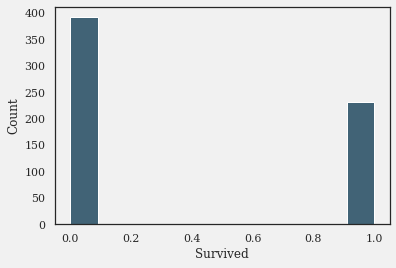

In [61]:
sns.histplot(data = y_train)

Target tem um certo desbalanceamento.

## Dealing with NaN and object type columns

In [ ]:
df.info()

In [62]:
# we can see how much (%) of each column is missing 
faltantes_percentual = (x_train.isnull().sum() / len(df.iloc[:,0])*100).sort_values(ascending=False)
faltantes_percentual

Cabin       54.320988
Age         13.916947
Embarked     0.112233
Pclass       0.000000
Name         0.000000
Sex          0.000000
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
dtype: float64

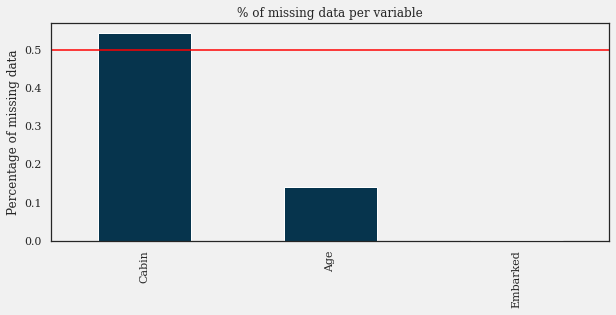

In [63]:
missing_feat = ['Cabin', 'Age', 'Embarked']
(x_train[missing_feat].isnull().sum()
    /len(df.iloc[:,0])).sort_values(
    ascending=False).plot.bar(figsize=(10, 4))

plt.ylabel('Percentage of missing data')
plt.title('% of missing data per variable')
plt.axhline(y=0.5, color='red', linestyle='-')
plt.show()

In [66]:
x_eda

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_code,Cabin_Size,Title
PassengerId,,,,,,,,,,
446,1,1,4.0,0,2,81.8583,S,A,1,Master
651,3,1,?,0,0,7.8958,S,?,1,Mr
173,3,0,1.0,1,1,11.1333,S,?,1,Miss
451,2,1,36.0,1,2,27.7500,S,?,1,Mr
315,2,1,43.0,1,1,26.2500,S,?,1,Mr
...,...,...,...,...,...,...,...,...,...,...
107,3,0,21.0,0,0,7.6500,S,?,1,Miss
271,1,1,?,0,0,31.0000,S,?,1,Mr
861,3,1,41.0,2,0,14.1083,S,?,1,Mr


In [90]:
for var in ['Sex','Embarked', 'Cabin_code', 'Title','Pclass']:
    
    # find the frequent categories
    frequent_ls = find_frequent_labels(x_eda, var, 0.05)
    
    print(var, frequent_ls)
    print()
    
    x_eda_rare = x_eda.copy()
    # replace rare categories by the string "Rare"
    #x_eda_rare[var] = np.where(x_eda[var].isin(frequent_ls), x_eda[var], 'Rare')
    
    #x_test[var] = np.where(x_test[var].isin(
     #   frequent_ls), x_test[var], 'Rare')

Sex Int64Index([0, 1], dtype='int64', name='Sex')

Embarked Index(['C', 'Q', 'S'], dtype='object', name='Embarked')

Cabin_code Index(['?', 'B', 'C'], dtype='object', name='Cabin_code')

Title Index(['Miss', 'Mr', 'Mrs'], dtype='object', name='Title')

Pclass Int64Index([1, 2, 3], dtype='int64', name='Pclass')



# Outliers

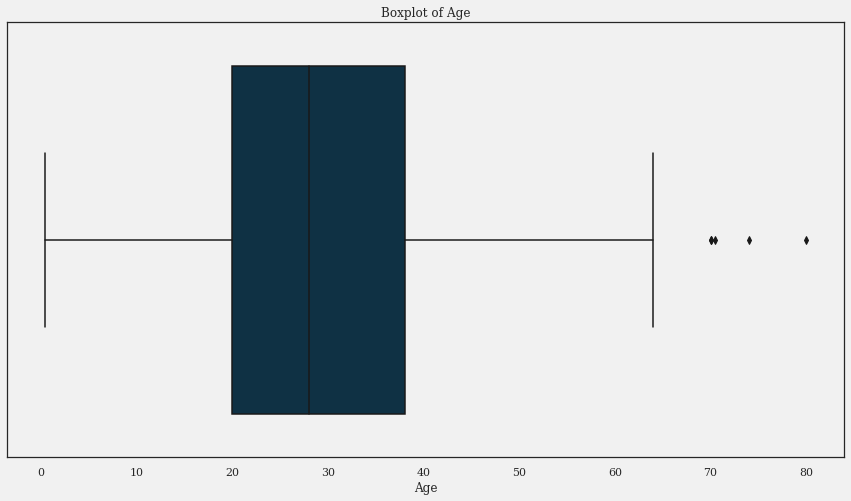

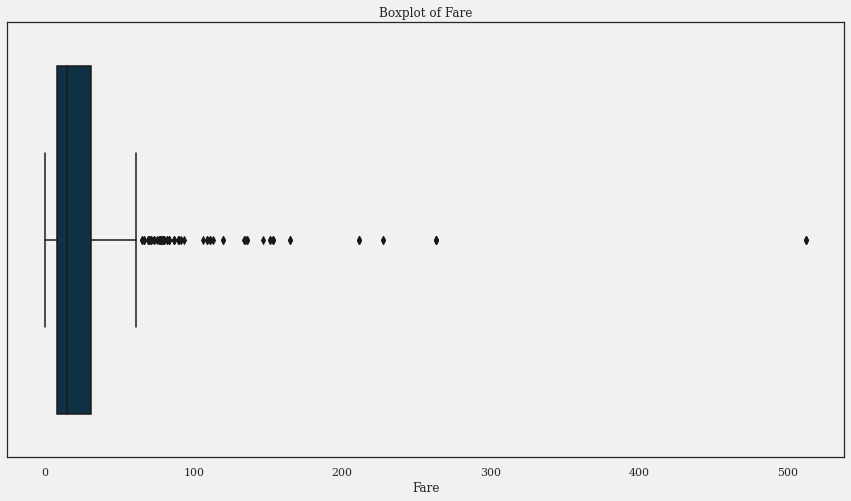

In [252]:
plt.rcParams['figure.figsize']=(15,8)
for var in ['Age','Fare']:
    sns.boxplot(data=x_train, x=var)
    plt.title(f'Boxplot of {var}')
    plt.show()

In [145]:
x_eda3 = x_eda.copy()
x_eda3['Age'] = x_eda['Age'].replace('?', np.nan)

#identificanfo quantil = 95%
for x in ['Age', 'Fare']:
    print(x,x_eda3[x].quantile(0.95))

Age 55.0
Fare 108.9


In [353]:
# quantiles approach
a = x_train[x_train['Age']>55].index
b = x_train[x_train['Fare']>108.9].index
c=[]
for x in a:
    if x in b:
        c.append(x)
print('dados outliers em Age e Fare junto:',c)

dados outliers em Age e Fare junto: [269, 196, 439]


In [249]:
# 3 sigma limit
age_upper_limit = x_train['Age'].mean() + 3*x_train['Age'].std()
age_lower_limit = x_train['Age'].mean() - 3*x_train['Age'].std()
print('Age',age_upper_limit, age_lower_limit)

# 3 sigma limit
age_upper_limit = x_train['Fare'].mean() + 3*x_train['Fare'].std()
age_lower_limit = x_train['Fare'].mean() - 3*x_train['Fare'].std()
print('Fare',age_upper_limit, age_lower_limit)

Age 72.93205448360665 -14.419349072785
Fare 184.92284449982756 -121.24138543080677


# Correlação

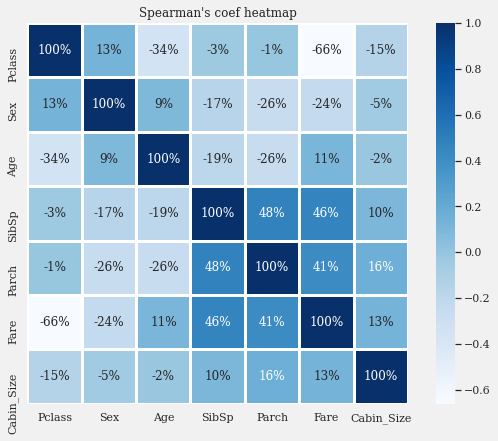

In [366]:
# make a copy to be manipulated
x_eda_corr = x_eda.copy()
# replace the missing marker "?" for NaN in Age
x_eda_corr['Age'] = x_eda_corr['Age'].replace('?', np.nan)
# transform column 'Age' into float 
x_eda_corr['Age'] = x_eda_corr['Age'].astype('float')

#plot
fig=plt.figure(figsize=(10,7))
axis=sns.heatmap(x_eda_corr.corr(method='spearman'), annot=True, linewidths=3, square=True, cmap='Blues', fmt=".0%",)
plt.title("Spearman's coef heatmap")
plt.show()

Text(0.5, 1.0, 'Violin plot de Fare por Pclass')

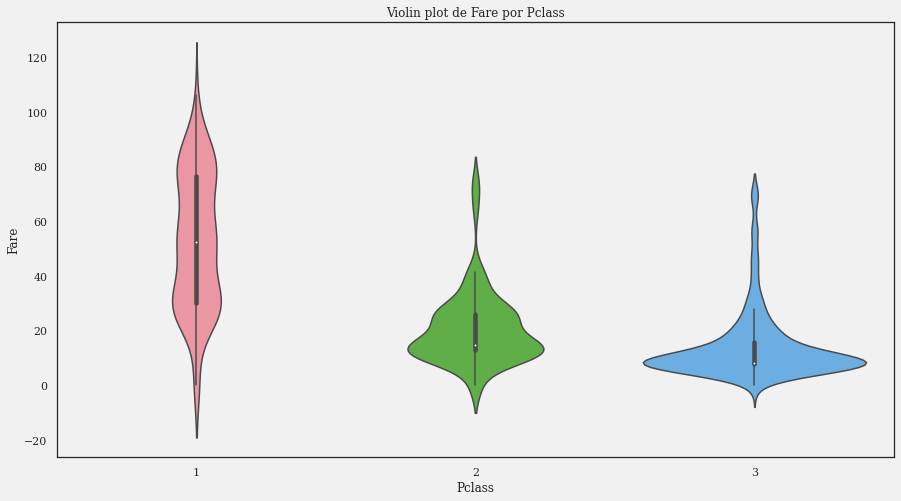

In [375]:
#checking the correlation between pclass and fare
sns.violinplot(x_eda['Pclass'],x_eda[x_eda['Fare']<x_eda['Fare'].quantile(0.95)]['Fare'])
plt.title('Violin plot de Fare por Pclass')

<AxesSubplot:xlabel='Pclass', ylabel='Fare'>

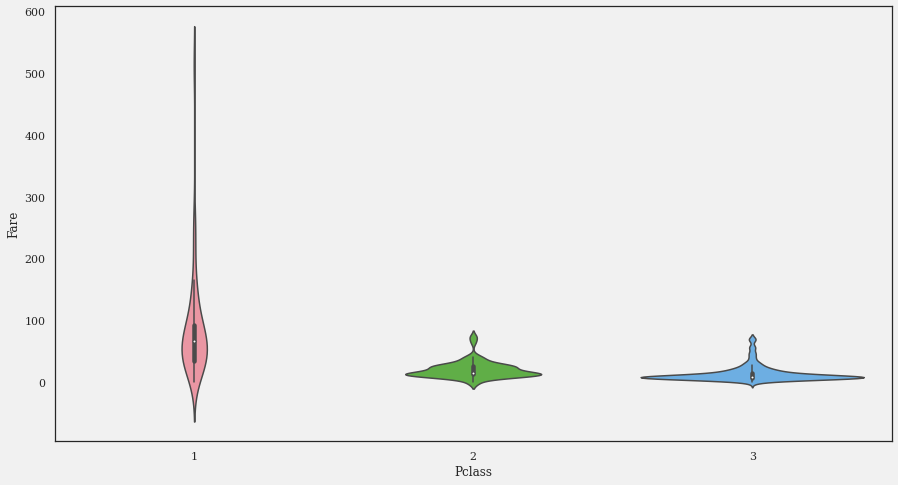

In [370]:
#checking the correlation between pclass and fare
sns.violinplot(x_eda['Pclass'],x_eda['Fare'])

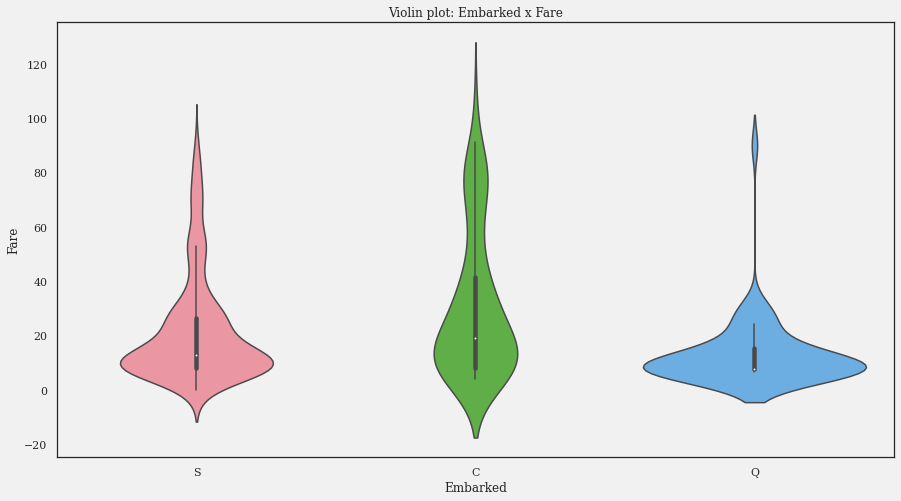

In [386]:
x_eda_emb = x_eda.copy()
x_eda_emb['Embarked'] = x_eda_emb['Embarked'].replace('?', np.nan)

#checking the correlation between pclass and fare
sns.violinplot(x_eda_emb['Embarked'],x_eda[x_eda['Fare']<x_eda['Fare'].quantile(0.95)]['Fare'])
plt.title('Violin plot: Embarked x Fare')
plt.show()

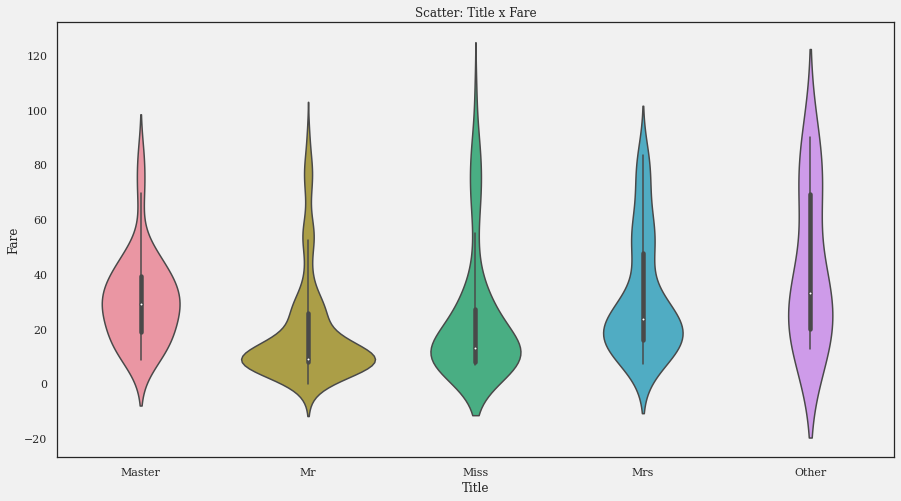

In [397]:
#checking the correlation between pclass and fare
sns.violinplot(x_eda['Title'],x_eda[x_eda['Fare']<x_eda['Fare'].quantile(0.95)]['Fare'])
plt.title('Scatter: Title x Fare')
plt.show()

In [356]:
x_eda.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_code,Cabin_Size,Title
PassengerId,,,,,,,,,,
446,1,1,4.0,0,2,81.8583,S,A,1,Master
651,3,1,?,0,0,7.8958,S,?,1,Mr
173,3,0,1.0,1,1,11.1333,S,?,1,Miss
451,2,1,36.0,1,2,27.7500,S,?,1,Mr
315,2,1,43.0,1,1,26.2500,S,?,1,Mr


# Baseline

In [153]:
x_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
446,1,"Dodge, Master. Washington",male,4.0,0,2,33638,81.8583,A34,S
651,3,"Mitkoff, Mr. Mito",male,NaN,0,0,349221,7.8958,NaN,S
173,3,"Johnson, Miss. Eleanor Ileen",female,1.0,1,1,347742,11.1333,NaN,S
451,2,"West, Mr. Edwy Arthur",male,36.0,1,2,C.A. 34651,27.7500,NaN,S
315,2,"Hart, Mr. Benjamin",male,43.0,1,1,F.C.C. 13529,26.2500,NaN,S


In [203]:
#basic pre processing 
pipe_base = make_pipeline(
                        MeanMedianImputer(imputation_method='mean', variables=['Age']),
                        Fill_na_transf(fill_na="?"),
                        Cabin_code(),
                        Get_title(),
                        Mapper(features=['Sex'],map_dict = sex_map),
                        OneHotEncoder(top_categories = 3, variables=['Cabin_code','Title','Embarked']),
                        DropFeatures(features_to_drop=['Name','Ticket','Cabin']),
                        RandomForestClassifier(random_state=42))

In [223]:
score_base = cross_val_score(pipe_base, x_train, y_train, cv=5)
print(f'accuracy of {np.round(score_base.mean(),4)} and standard deviation of {np.round(score_base.std(),4)}')

accuracy of 0.8187 and standard deviation of 0.0362


So we have our baseline now.

# Feature Engeneer

In [330]:
# filling na of "Age" with median instead of mean
pipe_base2 = make_pipeline(
                        MeanMedianImputer(imputation_method='mean', variables=['Age']),
                        Fill_na_transf(fill_na="?"),
                        Cabin_code(),
                        Get_title(),
                        Mapper(features=['Sex'],map_dict = sex_map),
                        OneHotEncoder(top_categories = 3, variables=['Cabin_code','Title','Embarked']),
                        DropFeatures(features_to_drop=['Name','Ticket','Cabin']),
                        Winsorizer(variables=["Age","Fare"],capping_method='quantiles', fold=0.05),
                        RandomForestClassifier(random_state=42))

In [331]:
score_base2 = cross_val_score(pipe_base2, x_train, y_train, cv=5)
print(f'accuracy of {np.round(score_base2.mean(),4)} and standard deviation of {np.round(score_base2.std(),4)}')

accuracy of 0.8236 and standard deviation of 0.0357


In [402]:
x_eda[x_eda['SibSp']>5]

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_code,Cabin_Size,Title
PassengerId,,,,,,,,,,
325,3,1,?,8,2,69.55,S,?,1,Mr
793,3,0,?,8,2,69.55,S,?,1,Miss
181,3,0,?,8,2,69.55,S,?,1,Miss
864,3,0,?,8,2,69.55,S,?,1,Miss
847,3,1,?,8,2,69.55,S,?,1,Mr
160,3,1,?,8,2,69.55,S,?,1,Master
202,3,1,?,8,2,69.55,S,?,1,Mr


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
60,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9,NaN,S
481,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9,NaN,S
387,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.9,NaN,S
684,3,"Goodwin, Mr. Charles Edward",male,14.0,5,2,CA 2144,46.9,NaN,S
72,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.9,NaN,S


In [423]:
x_fem.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Cabin_code,Cabin_Size,Title
PassengerId,,,,,,,,,,
173,3,0,1.0,1,1,11.1333,S,?,1,Miss
802,2,0,31.0,1,1,26.2500,S,?,1,Mrs
582,1,0,39.0,1,1,110.8833,C,C,1,Mrs
335,1,0,-1.0,1,0,133.6500,S,?,1,Mrs
29,3,0,-1.0,0,0,7.8792,Q,?,1,Miss


<AxesSubplot:xlabel='Parch', ylabel='Age'>

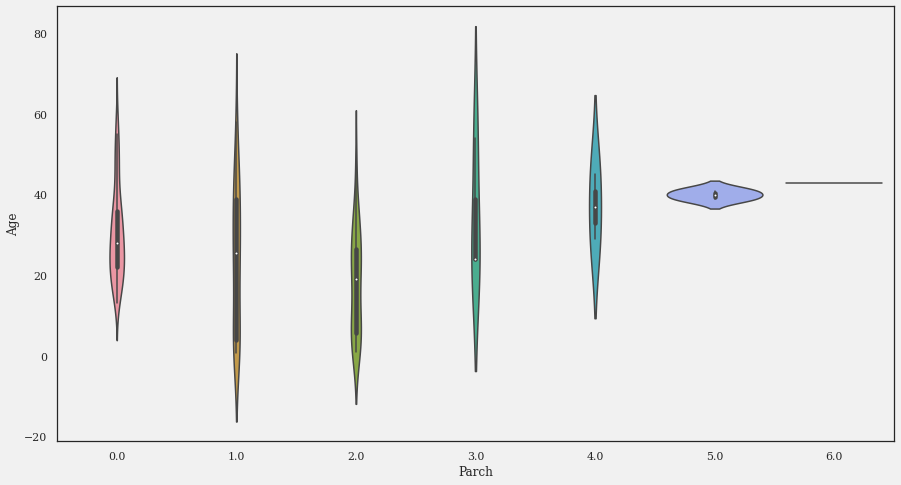

In [440]:
x_fem = x_eda[x_eda['Sex']==0]
x_fem['Age'] = x_fem['Age'].replace('?',np.nan)
x_fem['Age'] = x_fem['Age'].astype('float')
x_fem['Parch'] = x_fem['Parch'].astype('float')
sns.violinplot(x_fem['Parch'],x_fem['Age'])

In [473]:
#basic pre processing 
pipe_2 = make_pipeline(
                        MeanMedianImputer(imputation_method='mean', variables=['Age']),
                        Fill_na_transf(fill_na='?'),
                        Cabin_code(),
                        Get_title(),
                        Mapper(features=['Sex'],map_dict = sex_map),
                        OneHotEncoder(top_categories = 3, variables=['Cabin_code','Title','Embarked']),
                        DropFeatures(features_to_drop=['Name','Ticket','Cabin']))

In [474]:
x_eda_ = pipe_2.fit_transform(x_train)

In [476]:
algoritmo = SelectKBest(score_func=f_classif, k=10)
best_k_features = algoritmo.fit_transform(x_eda_,y_train)

scores_fclassif = pd.DataFrame(algoritmo.scores_,x_eda_.columns)

#print results
print(scores_fclassif.sort_values(by=0, ascending=False).head(10))

                       0
Title_Mr      251.580692
Sex           245.907141
Title_Mrs      94.181396
Pclass         67.080704
Cabin_code_?   64.614775
Title_Miss     61.333777
Fare           37.641272
Embarked_C     21.977995
Cabin_code_B   21.440811
Embarked_S     18.201298


In [ ]:
chi2 = SelectKBest(score_func=chi, k=10)
best_k_features = algoritmo.fit_transform(x_eda_,y_train)

scores_fclassif = pd.DataFrame(algoritmo.scores_,x_eda_.columns)

#print results
print(scores_fclassif.sort_values(by=0, ascending=False).head(10))